# Netflix Prize Dataset — Beginner-Friendly EDA (Fixed Loader)
This notebook works with your Netflix Prize files:

- `combined_data_1.txt` … `combined_data_4.txt`
- `movie_titles.csv`

## Steps
1. Set paths.
2. Load `movie_titles.csv` with correct parsing.
3. Stream combined data safely.
4. Build a sample.
5. Basic stats, popularity, user activity, time trends.
6. Save a compact dataset for modeling.

## 0. Imports and Setup

In [15]:
import os, random
from pathlib import Path
from itertools import islice
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 120)

## 1. Point to your data folder and load titles safely

In [16]:
from pathlib import Path
import pandas as pd

# 🔧 CHANGE THIS to your local path
DATA_DIR = Path("../Movie-Recommender/NetflixPrizeDataset").resolve()

# Check path
if not DATA_DIR.exists():
    raise FileNotFoundError(f"{DATA_DIR} does not exist")

# Combined files
combined_files = sorted(DATA_DIR.glob("combined_data_*.txt"))
print("Found combined data files:", [f.name for f in combined_files])

# Fixed loader for movie_titles.csv
TITLES_CSV = DATA_DIR / "movie_titles.csv"

def load_titles(path):
    rows = []
    with open(path, "r", encoding="latin1") as f:
        for line in f:
            if not line.strip():
                continue  # skip blank lines
            parts = line.strip().split(",", 2)  # split into 3 parts only
            if len(parts) == 3:
                movieId, year, title = parts
                try:
                    rows.append((int(movieId), int(year), title))
                except ValueError:
                    # skip any weird rows
                    continue
    return pd.DataFrame(rows, columns=["movieId","year","title"])

titles_df = load_titles(TITLES_CSV)
print("Titles loaded:", titles_df.shape)
titles_df.head()


Found combined data files: ['combined_data_1.txt', 'combined_data_2.txt', 'combined_data_3.txt', 'combined_data_4.txt']
Titles loaded: (17763, 3)


,movieId,year,title
0,1,2003,Dinosaur Planet
1,2,2004,Isle of Man TT 2004 Review
2,3,1997,Character
3,4,1994,Paula Abdul's Get Up & Dance
4,5,2004,The Rise and Fall of ECW


## 2. Stream Ratings Safely

In [17]:
def iter_ratings_from_combined(files):
    """Yield (movieId:int, userId:int, rating:int, date:str)"""
    for path in files:
        with open(path, 'r') as f:
            current_movie = None
            for line in f:
                line = line.strip()
                if not line:
                    continue
                if line.endswith(':'):
                    current_movie = int(line[:-1])
                else:
                    try:
                        userId, rating, date = line.split(',')
                        yield current_movie, int(userId), int(rating), date
                    except ValueError:
                        continue

# peek
peek = list(islice(iter_ratings_from_combined(combined_files), 5))
peek

[(1, 1488844, 3, '2005-09-06'),
 (1, 822109, 5, '2005-05-13'),
 (1, 885013, 4, '2005-10-19'),
 (1, 30878, 4, '2005-12-26'),
 (1, 823519, 3, '2004-05-03')]

## 3. Build a Sample DataFrame

In [7]:
SAMPLE_SIZE = 500_000  # adjust to your RAM

def build_sample(files, sample_size=SAMPLE_SIZE, seed=42):
    random.seed(seed)
    rows = []
    if sample_size is None:
        for movieId, userId, rating, date in iter_ratings_from_combined(files):
            rows.append((movieId, userId, rating, date))
    else:
        kept = 0
        for i, rec in enumerate(iter_ratings_from_combined(files), start=1):
            if kept < sample_size:
                rows.append(rec)
                kept += 1
            else:
                j = random.randint(0, i - 1)
                if j < sample_size:
                    rows[j] = rec
    df = pd.DataFrame(rows, columns=["movieId","userId","rating","date"])
    return df

sample_df = build_sample(combined_files, SAMPLE_SIZE)
print("Sample shape:", sample_df.shape)
sample_df.head()

Sample shape: (500000, 4)


,movieId,userId,rating,date
0,8172,1747393,4,2005-12-27
1,12161,850488,4,2005-02-26
2,11283,1834311,4,2004-07-09
3,6386,2131908,5,2004-05-15
4,3254,2029347,1,2003-08-20


## 4. Clean Types and Merge Titles

In [8]:
sample_df['movieId'] = sample_df['movieId'].astype('int32')
sample_df['userId'] = sample_df['userId'].astype('int32')
sample_df['rating']  = sample_df['rating'].astype('int8')
sample_df['date']    = pd.to_datetime(sample_df['date'], errors='coerce')

sample_df = sample_df.merge(titles_df, on='movieId', how='left')
sample_df.head(10)

,movieId,userId,rating,date,year,title
0,8172,1747393,4,2005-12-27,1999.0,Oklahoma!
1,12161,850488,4,2005-02-26,2003.0,Big Fish
2,11283,1834311,4,2004-07-09,1994.0,Forrest Gump
3,6386,2131908,5,2004-05-15,1992.0,Sister Act
4,3254,2029347,1,2003-08-20,2003.0,Daredevil
5,11443,2440330,3,2003-12-29,2002.0,Harry Potter and the Chamber of Secrets
6,7184,939769,3,2005-08-09,2005.0,Racing Stripes
7,13748,2208792,2,2004-09-21,1996.0,The First Wives Club
8,15163,1084694,3,2005-07-02,1998.0,The Prince of Egypt
9,10832,646398,4,2004-08-17,1960.0,Psycho


## 5. Basic Stats and Rating Distribution

Ratings: 500,000
Unique users: 216,392
Unique movies: 14,353
Date range: 1999-11-11 00:00:00 → 2005-12-31 00:00:00

Ratings value counts:
rating
1     23052
2     51082
3    142998
4    167830
5    115038
Name: count, dtype: int64


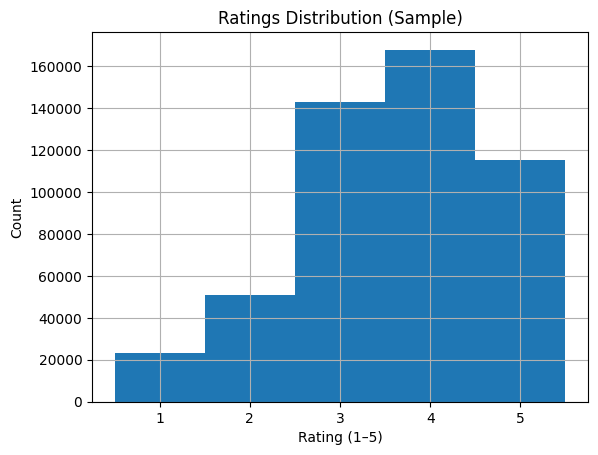

In [9]:
n_ratings = len(sample_df)
n_users = sample_df['userId'].nunique()
n_movies = sample_df['movieId'].nunique()

date_min = sample_df['date'].min()
date_max = sample_df['date'].max()

print(f"Ratings: {n_ratings:,}")
print(f"Unique users: {n_users:,}")
print(f"Unique movies: {n_movies:,}")
print(f"Date range: {date_min} → {date_max}")

print("\nRatings value counts:")
print(sample_df['rating'].value_counts().sort_index())

plt.figure()
sample_df['rating'].hist(bins=[0.5,1.5,2.5,3.5,4.5,5.5])
plt.xlabel('Rating (1–5)')
plt.ylabel('Count')
plt.title('Ratings Distribution (Sample)')
plt.show()

## 6. Movie Popularity

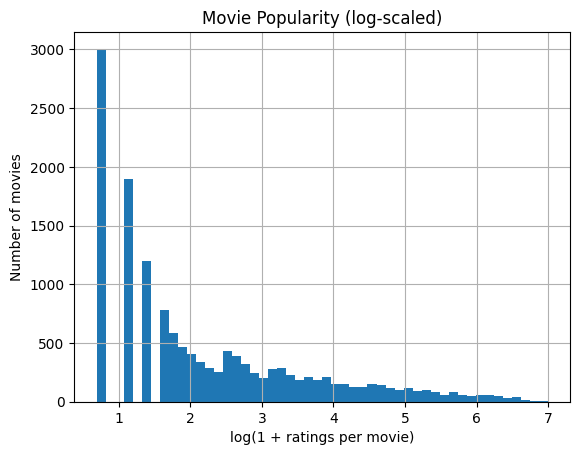

,movieId,n_ratings,year,title
0,5317,1093,2000,Miss Congeniality
1,15124,1084,1996,Independence Day
2,6287,1023,1990,Pretty Woman
3,1905,980,2003,Pirates of the Caribbean: The Curse of the Bla...
4,14313,951,2000,The Patriot
5,15205,945,2004,The Day After Tomorrow
6,16242,936,1997,Con Air
7,16377,900,1999,The Green Mile
8,9340,890,2001,Pearl Harbor
9,12470,868,1996,Twister


In [10]:
movie_pop = sample_df.groupby('movieId')['userId'].count().rename('n_ratings').sort_values(ascending=False)
plt.figure()
np.log1p(movie_pop).hist(bins=50)
plt.xlabel('log(1 + ratings per movie)')
plt.ylabel('Number of movies')
plt.title('Movie Popularity (log-scaled)')
plt.show()

top20_movies = movie_pop.head(20).reset_index().merge(titles_df, on='movieId', how='left')
top20_movies

## 7. User Activity

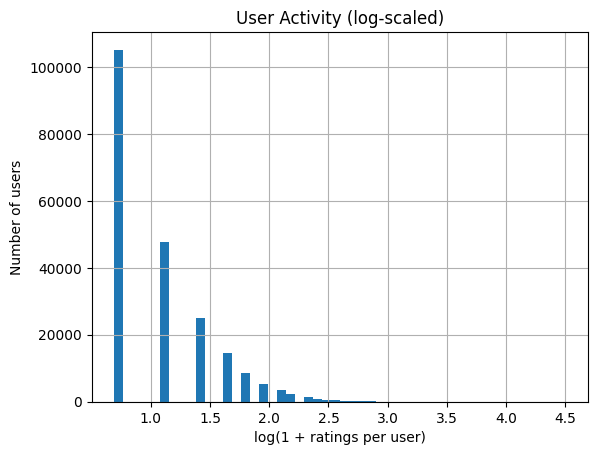

,userId,n_ratings
0,1664010,89
1,387418,85
2,2439493,83
3,305344,74
4,2118461,69
5,2606799,57
6,752642,47
7,1639792,47
8,1314869,46
9,1461435,46


In [11]:
user_activity = sample_df.groupby('userId')['movieId'].count().rename('n_ratings').sort_values(ascending=False)
plt.figure()
np.log1p(user_activity).hist(bins=50)
plt.xlabel('log(1 + ratings per user)')
plt.ylabel('Number of users')
plt.title('User Activity (log-scaled)')
plt.show()

user_activity.head(20).reset_index()

## 8. Temporal Patterns

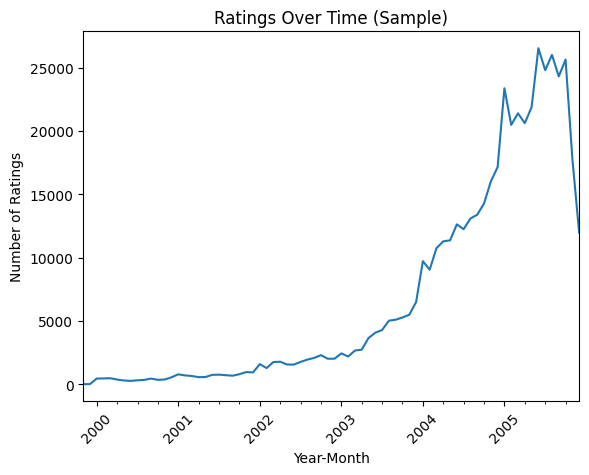

In [12]:
sample_df['year_month'] = sample_df['date'].dt.to_period('M')
ratings_by_month = sample_df.groupby('year_month')['rating'].count()

plt.figure()
ratings_by_month.sort_index().astype(int).plot(kind='line')
plt.xlabel('Year-Month')
plt.ylabel('Number of Ratings')
plt.title('Ratings Over Time (Sample)')
plt.xticks(rotation=45)
plt.show()

## 9. Matrix Sparsity

In [13]:
observed = len(sample_df)
density = observed / (n_users * n_movies)
print(f"Observed ratings: {observed:,}")
print(f"Users × Movies = {n_users:,} × {n_movies:,} = {n_users*n_movies:,}")
print(f"Approx. density in sample: {density:.6f} (~{density*100:.4f}%)")

Observed ratings: 500,000
Users × Movies = 216,392 × 14,353 = 3,105,874,376
Approx. density in sample: 0.000161 (~0.0161%)


## 10. Save Sample

In [14]:
OUT_DIR = DATA_DIR / "_eda_outputs"
OUT_DIR.mkdir(parents=True, exist_ok=True)

out_parquet = OUT_DIR / "ratings_sample.parquet"
try:
    sample_df.to_parquet(out_parquet, compression='snappy', index=False)
    print("Saved sample to", out_parquet)
except Exception as e:
    out_csv = OUT_DIR / "ratings_sample.csv.gz"
    sample_df.to_csv(out_csv, index=False, compression='gzip')
    print("Saved sample to", out_csv)

Saved sample to D:\AI Models\Movie-Recommender\NetflixPrizeDataset\_eda_outputs\ratings_sample.csv.gz


## Next Steps
- Try collaborative filtering using the sampled dataset.
- Try content-based by using year/title.
- Experiment with different sample sizes for performance vs. accuracy.
